# Trabajo Práctico 2: Selección de variables
Para la materia: Topicos avanzados en minería de datos - C2 2024

**Alumno:** [Joaquin Caporalini](mailto:joaquicaporalini@gmail.com)

**Docente:** [Pablo Granitto](mailto:granitto@cifasis-conicet.gov.ar)

In [114]:
install.packages("randomForest")
install.packages("kernlab")
install.packages("MASS")

Installing package into ‘/home/jcaporalini/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



Installing package into ‘/home/jcaporalini/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jcaporalini/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



## Ejercicio 1 - Implementaciones

 Prepare código en R para los métodos:
- **a.** Wrapper greedy backward
- **b.** Filter con test no-paramétrico (Kruskal-Wallis)
- **c.** RFE

### Wrapper Greedy forward

In [1]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para forward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if (verbosity>1) cat("\n\n-> Forward Ranking Start...\n\tnum iterations: ", max.feat)
	if( verbosity>2) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>2) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>3) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>1){
		cat("\n--------- Wrapper Greedy Forward ---------")
		cat("\n    ","Number of features: ", num.feat)
		cat("\n    ","Ranking: ", list.feat)
		cat("\n------------------------------------------\n")
	}

 	return(list.feat)

}


### Wrapper Greedy backward

In [2]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para backward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#selection <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
backward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat <- dim(x)[2]		# total de features
	num.feat <- max.feat    # numero actual de features
	list.feat <- 1:max.feat # lista para guardar los features elegidos, inicializo como llegaron

	selection <- numeric(max.feat) # voy a generar acá el orden de las variables

	if (verbosity>1) cat("\n\n-> Backward Ranking Start...\n\tnum iterations: ", max.feat)

  # loop principal.
	# Voy a sacar variables hasta agotarlas
	while(1 < num.feat){

		# vector de error
		class.error<-double(num.feat)

		if (verbosity > 2) cat("\n---------\nStep ",max.feat - num.feat)
		# para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:num.feat){
		  features <- list.feat[-i]
			x.train <- as.matrix(x[,features, drop = FALSE])
			if (verbosity > 3) cat("\ntraning with: ", i, "...")
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}

		less.relevant.index <- which.min(class.error)
		selection[num.feat] <- list.feat[less.relevant.index]

		if(verbosity>2){
			cat("\nFeatures:\n",list.feat,"\nErrors:\n",class.error, "\nFeature less relevant ",less.relevant.index)
		}

		list.feat <- list.feat[-less.relevant.index]

		if(verbosity>2) cat("\nOutstanding features: ",list.feat, "\n")

		num.feat<-num.feat-1 #proximo paso
	}

	selection[1] <- list.feat[1]

	if(verbosity>1){
		cat("\n--------- Wrapper Greedy Backward --------")
		cat("\n    ","Number of features: ", max.feat)
		cat("\n    ","Ranking: ", selection)
		cat("\n------------------------------------------\n")
	}

 	return(selection)

}


### Filter con test no-paramétrico (Kruskal-Wallis)

In [3]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para backward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
kruskalwallis.ranking <- function(x,y,verbosity=0,... )
{

	max.feat <- dim(x)[2]		    # total de features
	list.feat <- 1:max.feat     # lista para guardar los features elegidos, inicializo como llegaron
  p.value <- double(max.feat) #

	if (verbosity>1) cat("\n-> kruskalwallis Start...\n\tnum iterations: ", max.feat)


	for (i in 1:max.feat){
    col <- x[,i];

    # Analiso con kruskal sobre ´col´
    kruskal.result <- kruskal.test(col,y);
    p.value[i] <- kruskal.result$p.value;

    if(verbosity>2) cat("Variable: ", i," p-value: ", p.value[i], "\n");
  }

  # ordeno de forma
  sorted <- order(p.value, decreasing = FALSE);

  list.feat <- list.feat[sorted]

  if(verbosity>1){
		cat("\n-------------- kruskalwallis -------------")
		cat("\n    ","Number of features: ", max.feat)
		cat("\n    ","Ranking: ", list.feat)
		cat("\n------------------------------------------\n")
	}

 	return(list.feat)

}


### RFE (Recursive Feature Elimination)

In [4]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para backward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#feat.ranking <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
rfe.ranking <- function(x,y,method,verbosity=0,... )
{

	feat.num <- dim(x)[2]		# cantidad de features

	feat.ranking <- numeric(feat.num) # Orden de las
	feat.keep    <- 1:feat.num        #

	selection <- numeric(feat.num) # voy a generar acá el orden de las variables

	if (verbosity>1) cat("\n\n-> RFE Start...\n\tnum iterations: ", feat.num)


  # loop principal.
	# Voy a sacar variables hasta agotarlas
	for (i in 1:feat.num){
    # Me quedo con las caracteristicas deseadas en formato de matriz
    x.train <- as.matrix(x[,feat.keep])

    # Calculo el ranking de las caracteristicas a partir de las que todavía no
    # usé
    rankings <- do.call(method, c(list(x.train, y), list(...)))

    # Me quedo con la peor de todas las caracteristicas
    less.relevant.index <- rankings$feats[1]

    feat.ranking[i] <- feat.keep[less.relevant.index]

    feat.keep <- feat.keep[-less.relevant.index]

    if(verbosity > 2){
	  	cat("Iteration ",i ," Column less relevant index: ", "\n")
	  }

  }

  feat.ranking <- rev(feat.ranking)


  if(verbosity>1){
		cat("\n------------------ RFE ------------------")
		cat("\n    ","Number of features: ", feat.num)
		cat("\n    ","Ranking: ", feat.ranking)
		cat("\n------------------------------------------\n")
	}

 	return(feat.ranking)

}


## Calculo del error

In [5]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


In [6]:
#---------------------------------------------------------------------------
#Ejemplo de uso de las funciones de seleccion
#---------------------------------------------------------------------------
library(randomForest)
library(kernlab)
library(MASS)

#demo: aplicar el wrapper a los datos de iris
data(iris)
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est")

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.



## Test

In [7]:
#demo: aplicar el wrapper a los datos de iris
data(iris)

In [8]:
# Forward
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity = 3)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est", verbosity = 3)



-> Forward Ranking Start...
	num iterations:  4
First feature:  4 

Features:
 3 1 2 
Errors:
 0.03333333 0.04666667 0.06666667
---------
Step  2 
Feature  1
Features:
 1 2 
Errors:
 0.04666667 0.04666667
---------
Step  3 
Feature  1
Features:
 2 
Errors:
 0.04666667
---------
Step  4 
Feature  1
--------- Wrapper Greedy Forward ---------
     Number of features:  4
     Ranking:  4 3 1 2
------------------------------------------


-> Forward Ranking Start...
	num iterations:  4
First feature:  4 

Features:
 3 1 2 
Errors:
 0.04 0.04666667 0.04
---------
Step  2 
Feature  1
Features:
 1 2 
Errors:
 0.02666667 0.03333333
---------
Step  3 
Feature  1
Features:
 2 
Errors:
 0.02
---------
Step  4 
Feature  1
--------- Wrapper Greedy Forward ---------
     Number of features:  4
     Ranking:  4 3 1 2
------------------------------------------


In [9]:
# Backward
BACK.rf <-backward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity = 3)
BACK.lda<-backward.ranking(iris[,-5],iris[,5],method="lda.est", verbosity = 3)




-> Backward Ranking Start...
	num iterations:  4
---------
Step  0
Features:
 1 2 3 4 
Errors:
 0.06 0.05333333 0.04666667 0.07333333 
Feature less relevant  3
Outstanding features:  1 2 4 

---------
Step  1
Features:
 1 2 4 
Errors:
 0.07333333 0.05333333 0.3 
Feature less relevant  2
Outstanding features:  1 4 

---------
Step  2
Features:
 1 4 
Errors:
 0.04666667 0.2933333 
Feature less relevant  1
Outstanding features:  4 

--------- Wrapper Greedy Backward --------
     Number of features:  4
     Ranking:  4 1 2 3
------------------------------------------


-> Backward Ranking Start...
	num iterations:  4
---------
Step  0
Features:
 1 2 3 4 
Errors:
 0.03333333 0.02666667 0.05333333 0.04 
Feature less relevant  2
Outstanding features:  1 3 4 

---------
Step  1
Features:
 1 3 4 
Errors:
 0.04 0.04666667 0.04 
Feature less relevant  1
Outstanding features:  3 4 

---------
Step  2
Features:
 3 4 
Errors:
 0.04 0.06666667 
Feature less relevant  1
Outstanding features:  4 

-

In [10]:
# kruskalwallis
KRUS <-kruskalwallis.ranking(iris[,-5],iris[,5], verbosity = 3)



-> kruskalwallis Start...
	num iterations:  4Variable:  1  p-value:  8.918734e-22 
Variable:  2  p-value:  1.569282e-14 
Variable:  3  p-value:  4.803974e-29 
Variable:  4  p-value:  3.261796e-29 

-------------- kruskalwallis -------------
     Number of features:  4
     Ranking:  4 3 1 2
------------------------------------------


In [11]:
# RFE
RFE.rf     <-rfe.ranking(iris[,-5],iris[,5],method="imp.rf", verbosity = 3)
RFE.linsvm <-rfe.ranking(iris[,-5],iris[,5],method="imp.linsvm", verbosity = 3)



-> RFE Start...
	num iterations:  4Iteration  1  Column less relevant index:  
Iteration  2  Column less relevant index:  
Iteration  3  Column less relevant index:  
Iteration  4  Column less relevant index:  

------------------ RFE ------------------
     Number of features:  4
     Ranking:  4 3 1 2
------------------------------------------


-> RFE Start...
	num iterations:  4 Setting default kernel parameters  
Iteration  1  Column less relevant index:  
 Setting default kernel parameters  
Iteration  2  Column less relevant index:  
 Setting default kernel parameters  
Iteration  3  Column less relevant index:  
 Setting default kernel parameters  
Iteration  4  Column less relevant index:  

------------------ RFE ------------------
     Number of features:  4
     Ranking:  3 4 1 2
------------------------------------------


## Análisis de los datasets artificiales

### Generación de Datos

In [12]:
#---------------------------------------------------------------------------
#Codigo con datasets de ejemplo y para el TP2
#---------------------------------------------------------------------------
#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar

crea.ruido.unif<-function(n=100,d=2){
x<-runif(2*n*d,min=-1)	#genero los datos
dim(x)<-c(2*n,d)
return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con orden de importancia: 8-6-4-2
#---------------------------------------------------------------------------
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos


In [13]:
#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con dos variables relevantes (1-2) y dos variables que son importantes pero que no resuelven el problema (3-4)
#---------------------------------------------------------------------------
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos

### Mostrando los datos y analizando datos

#### A

Importance of components:
                          PC1    PC2    PC3    PC4    PC5     PC6     PC7
Standard deviation     1.0497 1.0350 1.0318 1.0202 1.0032 0.99218 0.98415
Proportion of Variance 0.1102 0.1071 0.1065 0.1041 0.1006 0.09844 0.09685
Cumulative Proportion  0.1102 0.2173 0.3238 0.4278 0.5285 0.62693 0.72378
                           PC8     PC9    PC10
Standard deviation     0.97605 0.95364 0.94871
Proportion of Variance 0.09527 0.09094 0.09001
Cumulative Proportion  0.81905 0.90999 1.00000

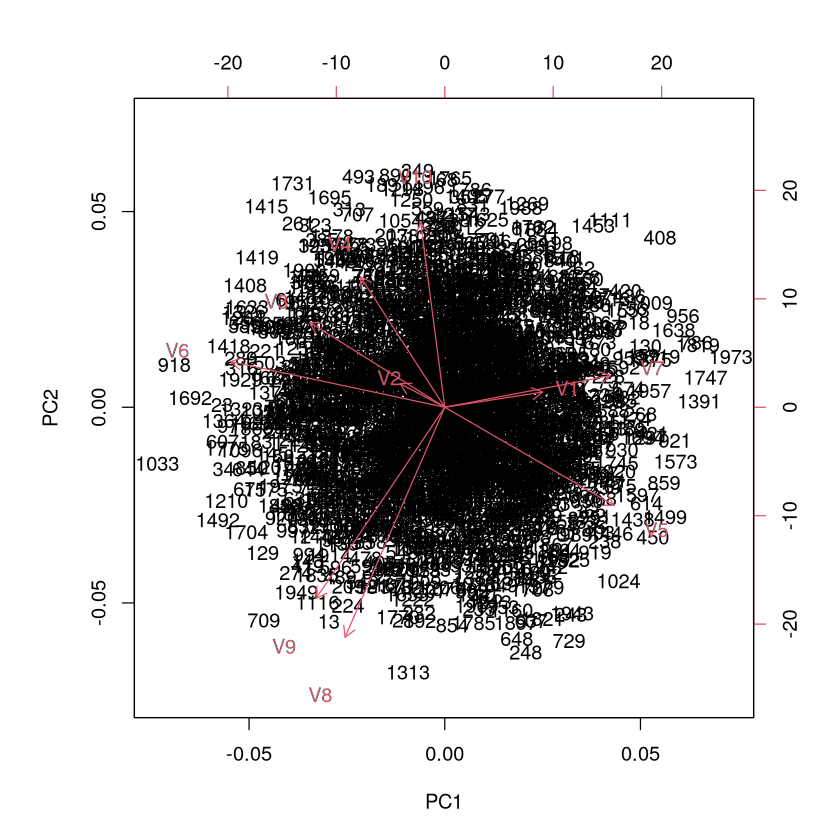

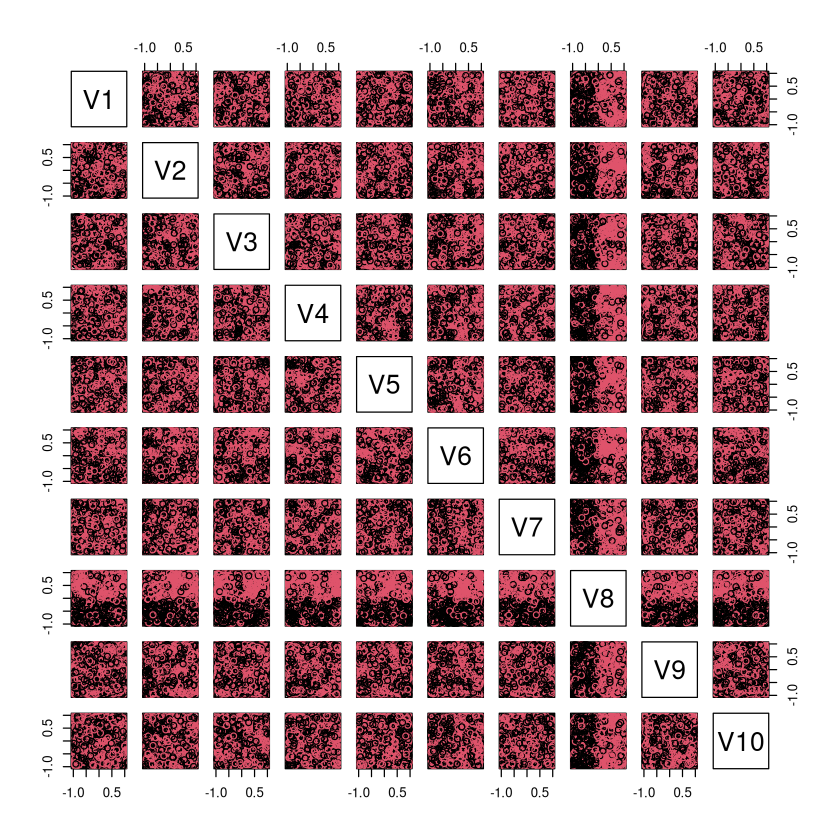

In [14]:
datosA.pca <- prcomp(datosA[,-11], scale. = TRUE)
summary(datosA.pca)
biplot(datosA.pca)
plot(datosA[,-11], col=datosA[,11])

In [15]:
datosA.x = datosA[,-11]
datosA.y = datosA[,11]

cat("Datos A:")
cat("\nOrden de importancia: 8-6-4-2")

datosA.FORW.rf <-  forward.ranking(datosA.x,datosA.y,method="rf.est", verbosity = 2)
datosA.FORW.lda <- forward.ranking(datosA.x,datosA.y,method="lda.est", verbosity = 2)

datosA.BACK.rf <-  backward.ranking(datosA.x,datosA.y,method="rf.est", tot.trees=100,equalize.classes=F, verbosity = 2)
datosA.BACK.lda <- backward.ranking(datosA.x,datosA.y,method="lda.est", verbosity = 2)

datosA.KRUS <-kruskalwallis.ranking(datosA.x,datosA.y, verbosity = 2)

datosA.RFE.rf     <-rfe.ranking(datosA.x,datosA.y,method="imp.rf", verbosity = 2)
datosA.RFE.linsvm <-rfe.ranking(datosA.x,datosA.y,method="imp.linsvm", verbosity = 2)


Datos A:
Orden de importancia: 8-6-4-2

-> Forward Ranking Start...
	num iterations:  10
--------- Wrapper Greedy Forward ---------
     Number of features:  10
     Ranking:  8 6 7 9 3 5 10 1 4 2
------------------------------------------


-> Forward Ranking Start...
	num iterations:  10
--------- Wrapper Greedy Forward ---------
     Number of features:  10
     Ranking:  8 10 9 3 7 5 1 2 4 6
------------------------------------------


-> Backward Ranking Start...
	num iterations:  10
--------- Wrapper Greedy Backward --------
     Number of features:  10
     Ranking:  8 9 1 10 5 4 7 6 3 2
------------------------------------------


-> Backward Ranking Start...
	num iterations:  10
--------- Wrapper Greedy Backward --------
     Number of features:  10
     Ranking:  8 7 9 3 10 5 1 2 4 6
------------------------------------------

-> kruskalwallis Start...
	num iterations:  10
-------------- kruskalwallis -------------
     Number of features:  10
     Ranking:  8 6 4 2 7 5 9 10 

#### B

Importance of components:
                          PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8
Standard deviation     1.0938 1.0375 1.0199 1.0014 0.9931 0.9745 0.9716 0.8966
Proportion of Variance 0.1496 0.1346 0.1300 0.1254 0.1233 0.1187 0.1180 0.1005
Cumulative Proportion  0.1496 0.2841 0.4142 0.5395 0.6628 0.7815 0.8995 1.0000

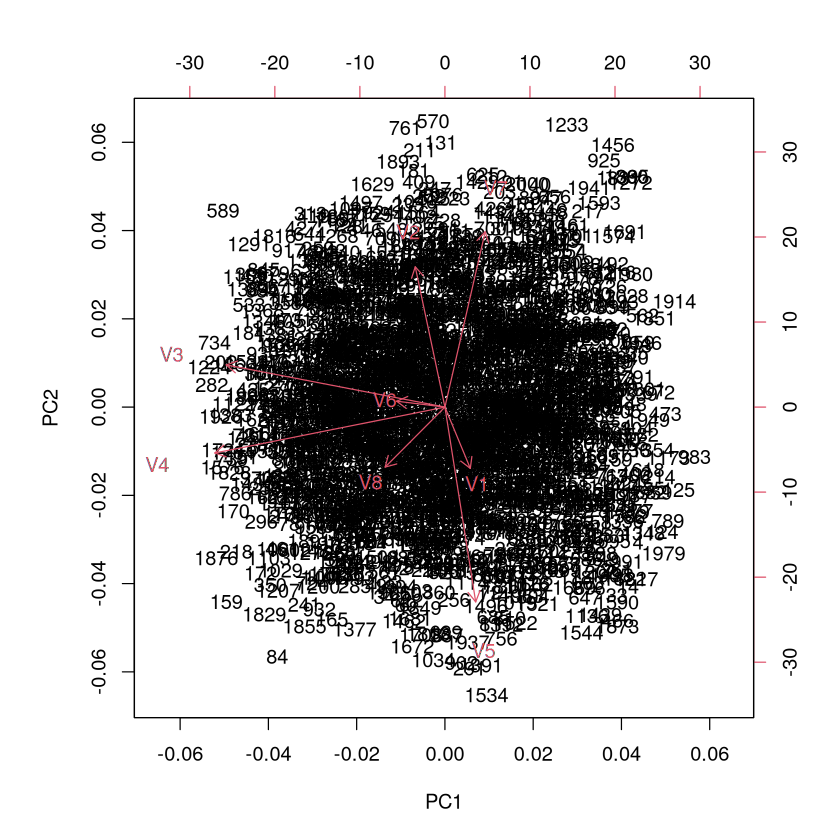

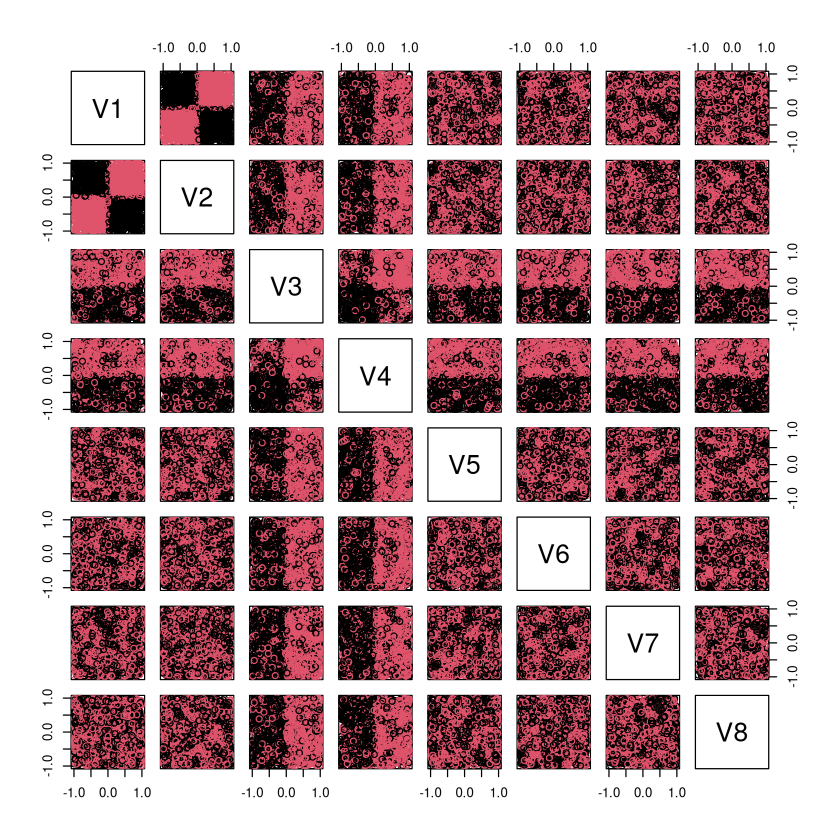

In [18]:
datosB.pca <- prcomp(datosB[,-9], scale. = TRUE)
summary(datosB.pca)
biplot(datosB.pca)
plot(datosB[,-9], col=datosB[,9])

In [19]:
datosB.x = datosB[,-9]
datosB.y = datosB[,9]

cat("Datos B:")
cat("\nOrden de importancia: 8-6-4-2")

datosB.FORW.rf <-  forward.ranking(datosB.x,datosB.y,method="rf.est", verbosity = 2)
datosB.FORW.lda <- forward.ranking(datosB.x,datosB.y,method="lda.est", verbosity = 2)

datosB.BACK.rf <-  backward.ranking(datosB.x,datosB.y,method="rf.est", tot.trees=100,equalize.classes=F, verbosity = 2)
datosB.BACK.lda <- backward.ranking(datosB.x,datosB.y,method="lda.est", verbosity = 2)

datosB.KRUS <-kruskalwallis.ranking(datosB.x,datosB.y, verbosity = 2)

datosB.RFE.rf     <-rfe.ranking(datosB.x,datosB.y,method="imp.rf", verbosity = 2)
datosB.RFE.linsvm <-rfe.ranking(datosB.x,datosB.y,method="imp.linsvm", verbosity = 2)


Datos B:
Orden de importancia: 8-6-4-2

-> Forward Ranking Start...
	num iterations:  8
--------- Wrapper Greedy Forward ---------
     Number of features:  8
     Ranking:  3 4 2 1 5 6 8 7
------------------------------------------


-> Forward Ranking Start...
	num iterations:  8
--------- Wrapper Greedy Forward ---------
     Number of features:  8
     Ranking:  3 4 2 1 7 5 8 6
------------------------------------------


-> Backward Ranking Start...
	num iterations:  8
--------- Wrapper Greedy Backward --------
     Number of features:  8
     Ranking:  2 1 5 7 8 6 3 4
------------------------------------------


-> Backward Ranking Start...
	num iterations:  8
--------- Wrapper Greedy Backward --------
     Number of features:  8
     Ranking:  3 4 2 1 8 5 7 6
------------------------------------------

-> kruskalwallis Start...
	num iterations:  8
-------------- kruskalwallis -------------
     Number of features:  8
     Ranking:  4 3 7 1 8 5 2 6
-------------------------------

## Problema de las diagonales en 10 dimenciones

In [20]:
generar_por_clase <- function(nombre, valor, dimension, cant, c){
  # Se generan todos los números para luego se agrupan y tabulan en una matriz
  datos <- matrix(rnorm(dimension * cant, mean = valor, sd = c * sqrt(dimension)), ncol = dimension);

  # Se agregan la categoria a cada punto
  return(cbind(datos, rep(nombre, cant)));
}

generar_datos_diagonal <- function(dimension, cant, c){
  # Para que tengamos misma cantdad de puntos por categoria
  cantPorClase <- floor(cant / 2);

  # Generamos cada categoría
  clase1 <- generar_por_clase(1,  1, dimension, cantPorClase, c);
  clase2 <- generar_por_clase(0, -1, dimension, cantPorClase, c);

  # Los unimos y transformamos en un dataFrame
  dataFrame <- as.data.frame(rbind(clase1, clase2));

  # Renomnramos las columnas para que representen cada componente y la clase
  colnames(dataFrame) <- c(paste0("i_", 1:dimension), "Clase")

  #
  dataFrame$Clase <- as.factor(dataFrame$Clase)
  return(dataFrame);
}

generar_datos_diagonal_noice <- function(dimension, cant, c, noice = 90){
  data <- generar_datos_diagonal(dimension, cant, c)
  data.x <- data[,-(dimension+1)]
  data.y <- data[,(dimension+1)]


  noice.data <- matrix(runif(cant * noice, min = -1, max = 1), ncol = noice)

  cols <-dimension+noice
  noice <- as.data.frame(cbind(data.x, noice.data, data.y))


  colnames(noice) <- c(paste0("i_", 1:cols), "Clase")
  noice$Clase <- as.factor(noice$Clase)

  return(noice)
}

In [21]:
datosD10 <- generar_datos_diagonal_noice(10, 50 * 2, 2)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6    PC7
Standard deviation     1.94604 1.88653 1.85346 1.81997 1.77128 1.74794 1.7145
Proportion of Variance 0.03787 0.03559 0.03435 0.03312 0.03137 0.03055 0.0294
Cumulative Proportion  0.03787 0.07346 0.10781 0.14094 0.17231 0.20286 0.2323
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.67054 1.62914 1.61657 1.56763 1.56000 1.52458 1.51765
Proportion of Variance 0.02791 0.02654 0.02613 0.02457 0.02434 0.02324 0.02303
Cumulative Proportion  0.26017 0.28671 0.31284 0.33742 0.36175 0.38500 0.40803
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     1.49196 1.47230 1.46013 1.44149 1.41207 1.39957 1.37132
Proportion of Variance 0.02226 0.02168 0.02132 0.02078 0.01994 0.01959 0.01881
Cumulative Proportion  0.43029 0.45196 0.47328 0.49406 0.51400 0.53359 0.55240
                          PC22

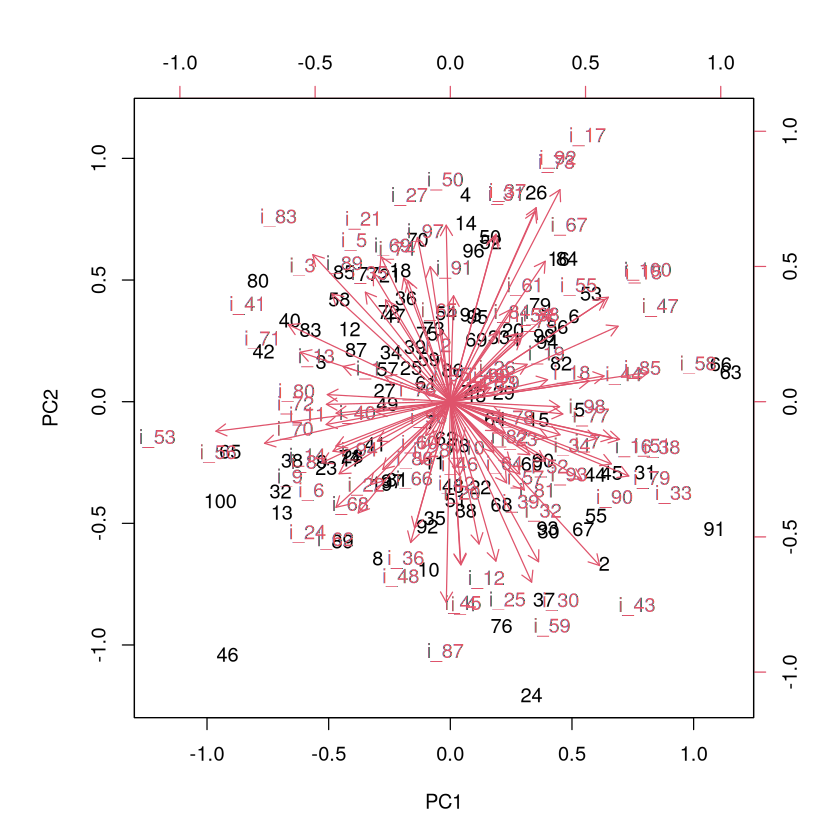

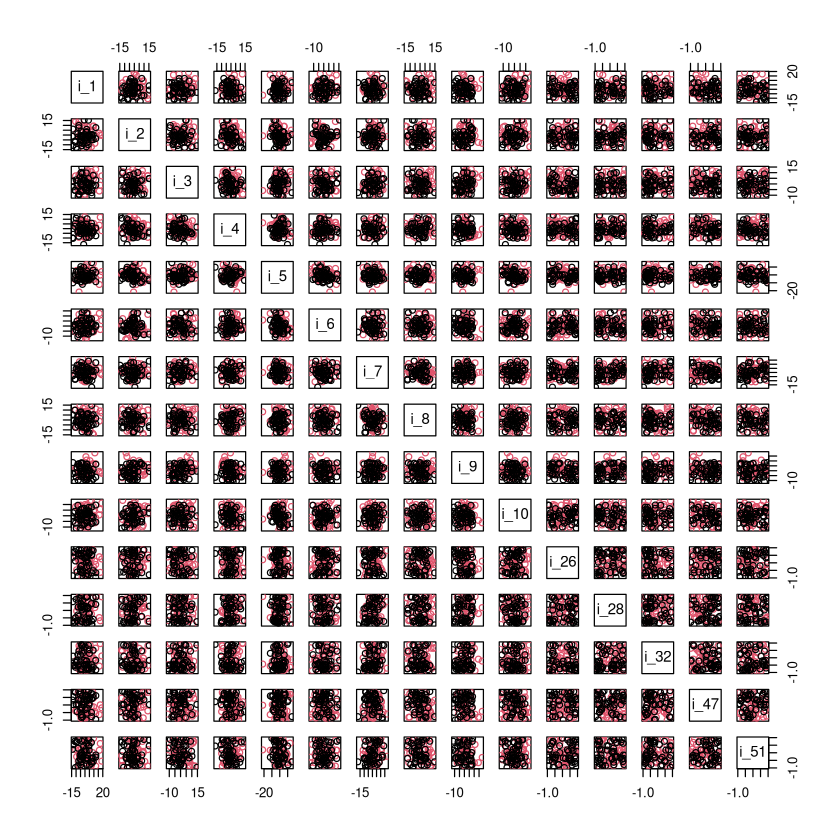

In [22]:
datosD10.pca <- prcomp(datosD10[-101], scale. = TRUE)
summary(datosD10.pca)
biplot(datosD10.pca, scale=0.5)
plot(datosD10[,c(1:10, sample(11:100, 5))], col=datosD10[,101])

In [23]:
ranking.successes <- function(ranking){
  ranking <- ranking[1:10]
  goal <- 0
  for (i in 1:10) if (i %in% ranking) goal <- goal + 0.1

  return(goal)
}

In [24]:
ITERATIONS = 50
VERBOSITY  = 1

diagonalD100.FORW.rf    <- array(ITERATIONS)
diagonalD100.FORW.lda   <- array(ITERATIONS)
diagonalD100.BACK.rf    <- array(ITERATIONS)
diagonalD100.BACK.lda   <- array(ITERATIONS)
diagonalD100.KRUS       <- array(ITERATIONS)
diagonalD100.RFE.rf     <- array(ITERATIONS)
diagonalD100.RFE.linsvm <- array(ITERATIONS)

if (VERBOSITY > 1){
  vv <- VERBOSITY - 1

} else
  vv <- 0

defaultW <- getOption("warn")
options(warn = -1)


for (i in 1:ITERATIONS){
  if (VERBOSITY > 0) cat("----------------------------------------- Iter= ", i, "\n")
  flush.console()

  if (VERBOSITY > 1) cat("Generando Datos\n")
  diagonalD100 <- generar_datos_diagonal_noice(10, 50 * 2, 2)
  diagonalD100.x <- diagonalD100[,-101]
  diagonalD100.y <- diagonalD100[,101]

  if (VERBOSITY > 1) cat(">>> Forward Ranking\n")
  ranking <- forward.ranking(diagonalD100.x,diagonalD100.y,method="rf.est", verbosity = vv)
  diagonalD100.FORW.rf[i] <-  ranking.successes(ranking)
  ranking <- forward.ranking(diagonalD100.x,diagonalD100.y,method="lda.est", verbosity = vv)
  diagonalD100.FORW.lda[i] <- ranking.successes(ranking)

  if (VERBOSITY > 1) cat(">>> Backward Ranking\n")
  ranking <- backward.ranking(diagonalD100.x,diagonalD100.y,method="rf.est", tot.trees=100,equalize.classes=F, verbosity = vv)
  diagonalD100.BACK.rf[i] <-  ranking.successes(ranking)
  ranking <- backward.ranking(diagonalD100.x,diagonalD100.y,method="lda.est", verbosity = vv)
  diagonalD100.BACK.lda[i] <- ranking.successes(ranking)

  if (VERBOSITY > 1) cat(">>> Kruskalwallis Rencontaranking\n")
  ranking <- kruskalwallis.ranking(diagonalD100.x,diagonalD100.y, verbosity = vv)
  diagonalD100.KRUS[i] <- ranking.successes(ranking)

  if (VERBOSITY > 1) cat(">>> Recursive Feature Elimination Ranking\n")
  ranking <- rfe.ranking(diagonalD100.x,diagonalD100.y,method="imp.rf", verbosity = vv)
  diagonalD100.RFE.rf[i]     <- ranking.successes(ranking)
  ranking <- rfe.ranking(diagonalD100.x,diagonalD100.y,method="imp.linsvm", verbosity = vv)
  diagonalD100.RFE.linsvm[i] <- ranking.successes(ranking)
}

dataFrame <- cbind(diagonalD100.FORW.rf, diagonalD100.FORW.lda, diagonalD100.BACK.rf, diagonalD100.BACK.lda, diagonalD100.KRUS, diagonalD100.RFE.rf, diagonalD100.RFE.linsvm )
colnames(dataFrame) <- c("FORW.rf", "FORW.lda", "BACK.rf", "BACK.lda", "KRUS", "RFE.rf", "RFE.linsvm")
dataFrame
summary(dataFrame)

----------------------------------------- Iter=  1 
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel

FORW.rf FORW.lda BACK.rf BACK.lda KRUS RFE.rf RFE.linsvm
 [1,] 0.0     0.1      0.0     0.0      0.3  0.1    0.1       
 [2,] 0.3     0.2      0.3     0.3      0.6  0.5    0.5       
 [3,] 0.2     0.2      0.0     0.0      0.3  0.2    0.1       
 [4,] 0.2     0.2      0.1     0.2      0.3  0.2    0.3       
 [5,] 0.2     0.3      0.2     0.2      0.3  0.4    0.4       
 [6,] 0.2     0.3      0.2     0.2      0.5  0.4    0.2       
 [7,] 0.0     0.1      0.0     0.1      0.4  0.2    0.3       
 [8,] 0.3     0.2      0.3     0.1      0.5  0.5    0.3       
 [9,] 0.1     0.2      0.1     0.3      0.5  0.4    0.2       
[10,] 0.1     0.0      0.2     0.1      0.4  0.2    0.2       
[11,] 0.2     0.2      0.1     0.2      0.3  0.3    0.5       
[12,] 0.3     0.2      0.2     0.3      0.4  0.3    0.3       
[13,] 0.3     0.2      0.1     0.1      0.4  0.4    0.3       
[14,] 0.1     0.0      0.1     0.1      0.4  0.2    0.0       
[15,] 0.2     0.2      0.2     0.1      0.2  0.2    0.2       
[16,] 0.0     0.1      0.4     0.1      0.4  0.4    0.4       
[17,] 0.2     0.0      0.1     0.1      0.4  0.3    0.3       
[18,] 0.2     0.3      0.3     0.0      0.4  0.4    0.3       
[19,] 0.1     0.2      0.1     0.1      0.3  0.3    0.2       
[20,] 0.2     0.2      0.2     0.1      0.4  0.3    0.3       
[21,] 0.2     0.3      0.3     0.2      0.4  0.3    0.3       
[22,] 0.1     0.1      0.1     0.2      0.3  0.2    0.3       
[23,] 0.0     0.1      0.1     0.1      0.2  0.1    0.1       
[24,] 0.0     0.2      0.1     0.1      0.5  0.4    0.3       
[25,] 0.3     0.2      0.3     0.1      0.3  0.3    0.4       
[26,] 0.1     0.3      0.1     0.2      0.3  0.2    0.1       
[27,] 0.1     0.5      0.2     0.3      0.6  0.6    0.3       
[28,] 0.4     0.3      0.2     0.3      0.7  0.5    0.5       
[29,] 0.2     0.1      0.1     0.2      0.2  0.3    0.2       
[30,] 0.1     0.3      0.2     0.3      0.4  0.3    0.6       
[31,] 0.1     0.3      0.1     0.2      0.4  0.3    0.3       
[32,] 0.2     0.1      0.1     0.1      0.2  0.2    0.2       
[33,] 0.2     0.1      0.2     0.0      0.4  0.3    0.2       
[34,] 0.2     0.6      0.2     0.3      0.6  0.4    0.6       
[35,] 0.1     0.3      0.0     0.1      0.5  0.4    0.3       
[36,] 0.2     0.2      0.1     0.1      0.5  0.4    0.5       
[37,] 0.1     0.1      0.1     0.3      0.2  0.2    0.4       
[38,] 0.3     0.3      0.2     0.1      0.4  0.5    0.4       
[39,] 0.2     0.2      0.1     0.2      0.3  0.4    0.4       
[40,] 0.3     0.1      0.4     0.3      0.4  0.5    0.3       
[41,] 0.1     0.3      0.2     0.0      0.2  0.2    0.3       
[42,] 0.0     0.0      0.1     0.1      0.2  0.3    0.2       
[43,] 0.1     0.5      0.0     0.2      0.5  0.4    0.3       
[44,] 0.2     0.3      0.2     0.4      0.4  0.5    0.2       
[45,] 0.2     0.3      0.2     0.1      0.3  0.3    0.3       
[46,] 0.1     0.4      0.2     0.2      0.4  0.4    0.3       
[47,] 0.1     0.1      0.0     0.3      0.3  0.1    0.1       
[48,] 0.1     0.1      0.3     0.2      0.4  0.4    0.5       
[49,] 0.2     0.2      0.2     0.0      0.3  0.3    0.1       
[50,] 0.0     0.3      0.2     0.2      0.4  0.3    0.4

    FORW.rf         FORW.lda        BACK.rf        BACK.lda          KRUS      
 Min.   :0.000   Min.   :0.000   Min.   :0.00   Min.   :0.000   Min.   :0.200  
 1st Qu.:0.100   1st Qu.:0.100   1st Qu.:0.10   1st Qu.:0.100   1st Qu.:0.300  
 Median :0.200   Median :0.200   Median :0.20   Median :0.150   Median :0.400  
 Mean   :0.158   Mean   :0.212   Mean   :0.16   Mean   :0.162   Mean   :0.378  
 3rd Qu.:0.200   3rd Qu.:0.300   3rd Qu.:0.20   3rd Qu.:0.200   3rd Qu.:0.400  
 Max.   :0.400   Max.   :0.600   Max.   :0.40   Max.   :0.400   Max.   :0.700  
     RFE.rf        RFE.linsvm   
 Min.   :0.100   Min.   :0.000  
 1st Qu.:0.200   1st Qu.:0.200  
 Median :0.300   Median :0.300  
 Mean   :0.324   Mean   :0.296  
 3rd Qu.:0.400   3rd Qu.:0.400  
 Max.   :0.600   Max.   :0.600  

## Dataset a la carta
### Fuente
El dataset fué extradido desde [Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/data) y trata sobre **Análisis de ataque cardíaco** y su predicción.

### Columnas
Las columnas que incluyen los datos son:

+ age :  Edad del paciente

+ sex : Sexo del paciente

+ cp : Tipo de dolor de pecho tipo dolor de dolor de dolor de dolor de dolor
    - Valor 1: angina típica
    - Valor 2: angina atípica
    - Valor 3: dolor no anginoso
    - Valor 4: asintomático
+ trtbps : Presión arterial en reposo (en mm Hg)

+ chol : Colestoral en mg/dl buscados a través del sensor IMC

+ fbs : (azúcar en sangre en rápida - 120 mg/dl) (1 = true; 0 = falso)

+ restecg : resultados del electrocardiograma en reposo
    - Valor 0: normal
    - Valor 1: con anormalidad en la onda ST-T (inversiones de la onda T y/o elevación o depresión del segmento ST de > 0,05 mV)
    - Valor 2: indicativo o probable hipertrofia ventricular izquierda según los criterios de Estes

+ thalachh : Frecuencia cardíaca máxima alcanzada

+ exng : [Angina](https://medlineplus.gov/spanish/angina.html) inducida por el ejercicio (1 = sí; 0 = no)

+ oldpeak : Pico previo

+ slp : la pendiente del segmento ST de ejercicio pico 
    - Valor 1: upsloping
    - Valor 2: plano
    - Valor 3: downsloping

+ caa : Número de vasos sanguíneos principales (0-3)

+ thall : Un trastorno sanguíneo llamado talasemia (1 = normal; 2 = defecto fijo; 3 = defecto reversible)

+ output : 0 = Menor probabilidad de ataque cardíaco, 1 = Mayor probabilidad de ataque cardíaco



In [25]:
# Cargo el CSV en el cual vienen los datos
datosHeart <- read.csv("archive/heart.csv")

# Convierto las variables categoricas a factores
# datosHeart$sex  <- as.factor(datosHeart$sex)
# datosHeart$fbs  <- as.factor(datosHeart$fbs)
# datosHeart$exng <- as.factor(datosHeart$exng)
datosHeart$output <- as.factor(datosHeart$output)

# Primer paso para separar categorias a one hot encoding
datosHeart$cp <- as.factor(datosHeart$cp)
datosHeart$restecg <- as.factor(datosHeart$restecg)
datosHeart$slp <- as.factor(datosHeart$slp)
# datosHeart$caa <- as.factor(datosHeart$caa)
datosHeart$thall <- as.factor(datosHeart$thall)

# Aplico one hot encoding
cp.onehot <- model.matrix(~cp-1, datosHeart)
restecg.onehot <- model.matrix(~restecg-1, datosHeart)
slp.onehot <- model.matrix(~slp-1, datosHeart)
# caa.onehot <- model.matrix(~caa-1, datosHeart)
thall.onehot <- model.matrix(~thall-1, datosHeart)

# Elimino las columnas originales
datosHeart <- datosHeart[,-c(3, 7, 11, 13)]

# Agrego las columnas nuevas
datosHeart.x <- datosHeart[,-10]
datosHeart.y <- datosHeart[,10]
datosHeart <- cbind(datosHeart.x, cp.onehot, restecg.onehot, slp.onehot, thall.onehot, datosHeart.y)
datosHeart <- as.data.frame(datosHeart)
# Nombres de las columnas
colnames(datosHeart) <- c("age", "sex", "trtbps", "chol", "fbs", "thalach", "exang", "caa", "oldpeak", "cp/tipica", "cp/atipica", "cp/dolor", "cp/asintomatico", "restecg/normal", "restecg/atipico", "restecg/hipertrofia", "slp/upsloping", "slp_plano", "slp_downsloping", "thall/sindatos", "thall/normal", "thall/d.fijo", "thall/d.reversible", "Output")

In [26]:
datosHeart

age sex trtbps chol fbs thalach exang caa oldpeak cp/tipica ⋯
1   63  1   145    233  1   150     0     2.3 0       0         ⋯
2   37  1   130    250  0   187     0     3.5 0       0         ⋯
3   41  0   130    204  0   172     0     1.4 0       0         ⋯
4   56  1   120    236  0   178     0     0.8 0       0         ⋯
5   57  0   120    354  0   163     1     0.6 0       1         ⋯
6   57  1   140    192  0   148     0     0.4 0       1         ⋯
7   56  0   140    294  0   153     0     1.3 0       0         ⋯
8   44  1   120    263  0   173     0     0.0 0       0         ⋯
9   52  1   172    199  1   162     0     0.5 0       0         ⋯
10  57  1   150    168  0   174     0     1.6 0       0         ⋯
11  54  1   140    239  0   160     0     1.2 0       1         ⋯
12  48  0   130    275  0   139     0     0.2 0       0         ⋯
13  49  1   130    266  0   171     0     0.6 0       0         ⋯
14  64  1   110    211  0   144     1     1.8 0       0         ⋯
15  58  0   150    283  1   162     0     1.0 0       0         ⋯
16  50  0   120    219  0   158     0     1.6 0       0         ⋯
17  58  0   120    340  0   172     0     0.0 0       0         ⋯
18  66  0   150    226  0   114     0     2.6 0       0         ⋯
19  43  1   150    247  0   171     0     1.5 0       1         ⋯
20  69  0   140    239  0   151     0     1.8 2       0         ⋯
21  59  1   135    234  0   161     0     0.5 0       1         ⋯
22  44  1   130    233  0   179     1     0.4 0       0         ⋯
23  42  1   140    226  0   178     0     0.0 0       1         ⋯
24  61  1   150    243  1   137     1     1.0 0       0         ⋯
25  40  1   140    199  0   178     1     1.4 0       0         ⋯
26  71  0   160    302  0   162     0     0.4 2       0         ⋯
27  59  1   150    212  1   157     0     1.6 0       0         ⋯
28  51  1   110    175  0   123     0     0.6 0       0         ⋯
29  65  0   140    417  1   157     0     0.8 1       0         ⋯
30  53  1   130    197  1   152     0     1.2 0       0         ⋯
⋮   ⋮   ⋮   ⋮      ⋮    ⋮   ⋮       ⋮     ⋮   ⋮       ⋮         ⋱
274 58  1   100    234  0   156     0     0.1 1       1         ⋯
275 47  1   110    275  0   118     1     1.0 1       1         ⋯
276 52  1   125    212  0   168     0     1.0 2       1         ⋯
277 58  1   146    218  0   105     0     2.0 1       1         ⋯
278 57  1   124    261  0   141     0     0.3 0       0         ⋯
279 58  0   136    319  1   152     0     0.0 2       0         ⋯
280 61  1   138    166  0   125     1     3.6 1       1         ⋯
281 42  1   136    315  0   125     1     1.8 0       1         ⋯
282 52  1   128    204  1   156     1     1.0 0       1         ⋯
283 59  1   126    218  1   134     0     2.2 1       0         ⋯
284 40  1   152    223  0   181     0     0.0 0       1         ⋯
285 61  1   140    207  0   138     1     1.9 1       1         ⋯
286 46  1   140    311  0   120     1     1.8 2       1         ⋯
287 59  1   134    204  0   162     0     0.8 2       0         ⋯
288 57  1   154    232  0   164     0     0.0 1       0         ⋯
289 57  1   110    335  0   143     1     3.0 1       1         ⋯
290 55  0   128    205  0   130     1     2.0 1       1         ⋯
291 61  1   148    203  0   161     0     0.0 1       1         ⋯
292 58  1   114    318  0   140     0     4.4 3       1         ⋯
293 58  0   170    225  1   146     1     2.8 2       1         ⋯
294 67  1   152    212  0   150     0     0.8 0       0         ⋯
295 44  1   120    169  0   144     1     2.8 0       1         ⋯
296 63  1   140    187  0   144     1     4.0 2       1         ⋯
297 63  0   124    197  0   136     1     0.0 0       1         ⋯
298 59  1   164    176  1    90     0     1.0 2       1         ⋯
299 57  0   140    241  0   123     1     0.2 0       1         ⋯
300 45  1   110    264  0   132     0     1.2 0       0         ⋯
301 68  1   144    193  1   141     0     3.4 2       1         ⋯
302 57  1   130    131  0   115     1     1.

In [27]:
summary(datosHeart)

      age             sex             trtbps           chol      
 Min.   :29.00   Min.   :0.0000   Min.   : 94.0   Min.   :126.0  
 1st Qu.:47.50   1st Qu.:0.0000   1st Qu.:120.0   1st Qu.:211.0  
 Median :55.00   Median :1.0000   Median :130.0   Median :240.0  
 Mean   :54.37   Mean   :0.6832   Mean   :131.6   Mean   :246.3  
 3rd Qu.:61.00   3rd Qu.:1.0000   3rd Qu.:140.0   3rd Qu.:274.5  
 Max.   :77.00   Max.   :1.0000   Max.   :200.0   Max.   :564.0  
      fbs            thalach          exang             caa      
 Min.   :0.0000   Min.   : 71.0   Min.   :0.0000   Min.   :0.00  
 1st Qu.:0.0000   1st Qu.:133.5   1st Qu.:0.0000   1st Qu.:0.00  
 Median :0.0000   Median :153.0   Median :0.0000   Median :0.80  
 Mean   :0.1485   Mean   :149.6   Mean   :0.3267   Mean   :1.04  
 3rd Qu.:0.0000   3rd Qu.:166.0   3rd Qu.:1.0000   3rd Qu.:1.60  
 Max.   :1.0000   Max.   :202.0   Max.   :1.0000   Max.   :6.20  
    oldpeak         cp/tipica        cp/atipica       cp/dolor     
 Min.   

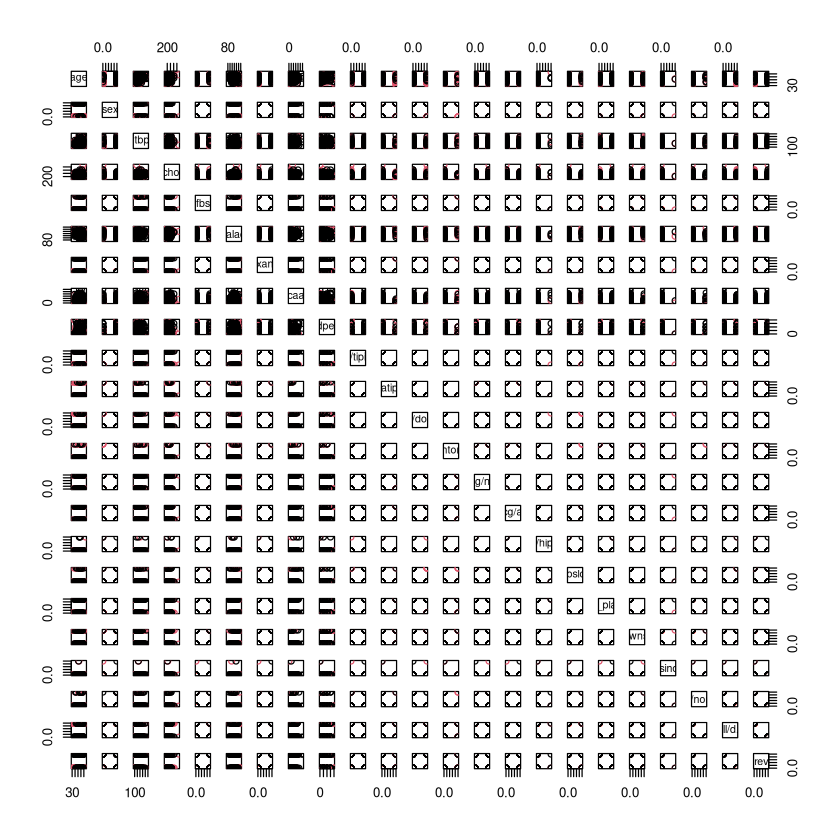

In [28]:
datosHeart.x <- datosHeart[,-24, drop = FALSE]
datosHeart.y <- datosHeart[,24]
plot(datosHeart.x, col=datosHeart.y)

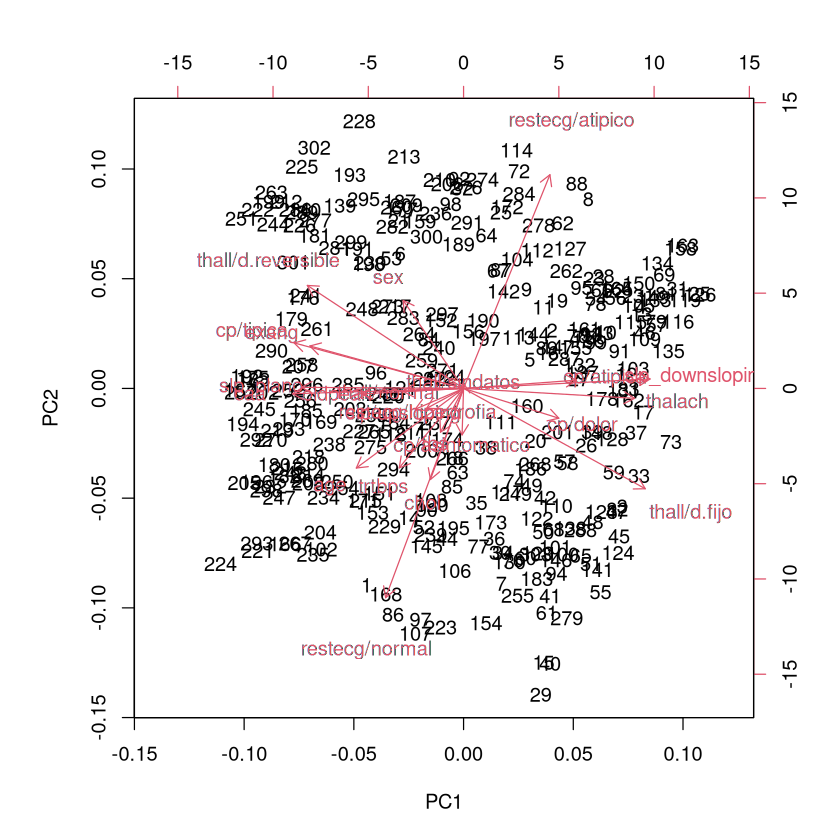

In [29]:
datosHeart.pca <- prcomp(datosHeart[,-24], scale. = TRUE)
biplot(datosHeart.pca)

In [30]:
datosHeart.FORW.rf <-  forward.ranking(datosHeart.x,datosHeart.y,method="rf.est",verbosity = 2)
datosHeart.FORW.lda <- forward.ranking(datosHeart.x,datosHeart.y,method="lda.est", verbosity = 2)

datosHeart.BACK.rf <-  backward.ranking(datosHeart.x,datosHeart.y,method="rf.est", tot.trees=100,equalize.classes=F, verbosity = 2)
datosHeart.BACK.lda <- backward.ranking(datosHeart.x,datosHeart.y,method="lda.est", verbosity = 2)

datosHeart.KRUS <-kruskalwallis.ranking(datosHeart.x,datosHeart.y, verbosity = 2)

datosHeart.RFE.rf     <-rfe.ranking(datosHeart.x,datosHeart.y,method="imp.rf", verbosity = 2)
datosHeart.RFE.linsvm <-rfe.ranking(datosHeart.x,datosHeart.y,method="imp.linsvm", verbosity = 2)




-> Forward Ranking Start...
	num iterations:  23
--------- Wrapper Greedy Forward ---------
     Number of features:  23
     Ranking:  22 13 6 12 20 10 9 23 7 18 15 1 19 21 11 17 16 5 14 2 3 8 4
------------------------------------------


-> Forward Ranking Start...
	num iterations:  23
--------- Wrapper Greedy Forward ---------
     Number of features:  23
     Ranking:  22 6 10 9 7 19 23 16 18 17 12 11 13 5 1 2 3 8 15 14 4 21 20
------------------------------------------


-> Backward Ranking Start...
	num iterations:  23
--------- Wrapper Greedy Backward --------
     Number of features:  23
     Ranking:  10 18 9 7 22 15 1 20 11 21 19 17 2 13 12 8 14 4 6 3 5 16 23
------------------------------------------


-> Backward Ranking Start...
	num iterations:  23
--------- Wrapper Greedy Backward --------
     Number of features:  23
     Ranking:  22 9 19 13 12 7 11 8 6 15 2 18 23 1 21 20 17 16 14 10 3 4 5
------------------------------------------

-> kruskalwallis Start...
	num it

### Conclusiones 
Los resultados que se observan tras aplicar los distintos métodos son de lo más variopintos. Una de las variables que destaca por su precencia son la **22**, **10** y **9** o por sus nombres son **thall/d.fijo**, **cp/tipica** y **oldpeak**, en pocas palabras tener dolor, no tener trastornos sanguineos y los picos anteriores son claves para la detección de infartos.
